# **IMPORT DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Akeed_Competition/"

In [ ]:
import gc
import math
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
import pandas as pd
import warnings
warnings.simplefilter('ignore')
test_customers=pd.read_csv(path +'test_customers.csv')
test_locations=pd.read_csv(path +'test_locations.csv')
train_customers=pd.read_csv(path +'train_customers.csv')
train_locations=pd.read_csv(path +'train_locations.csv')
vendors=pd.read_csv(path +'vendors.csv')
vendors = vendors.add_prefix('v_')

orders=pd.read_csv(path +'orders.csv')

CPU times: user 826 ms, sys: 142 ms, total: 967 ms
Wall time: 4.78 s


# **Create final train & test**

In [ ]:
def reduce_mem_usage(df, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)

  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

  return df

In [ ]:
def prepare_orders(orders) :
    
    ################################### NEW NEW NEW NEW ###################################################################
                 # 1- loc_rate
                 # 2- some aggs
    loc_rate = orders.groupby(by="LOCATION_NUMBER",as_index=False).agg({'driver_rating' : ['min','mean'], } )
    orders = pd.merge(orders,loc_rate,how='left',on="LOCATION_NUMBER")

    vendor_stats = orders.groupby(by="vendor_id",as_index=False).agg({ 
        'customer_id':['count','nunique'],
        'item_count':['mean','min' ,'std'],
        'grand_total':['mean','min' ,'std'],
        'driver_rating' : ['mean','std'],
        'deliverydistance' : ['std','mean','min'],
        
        })
    vendor_stats.columns = ["_".join(x) for x in vendor_stats.columns.ravel()]
    
    vendor_stats['nb_reordered'] = (vendor_stats['customer_id_count']-vendor_stats['customer_id_nunique'])
    
    
    return vendor_stats

In [ ]:
def prepare_vendors(vendors,vendor_stats):

      #merging stats with vendors
      vendors = pd.merge(vendors,vendor_stats,how="left",right_on="vendor_id_",left_on="v_id")
      
      
      
      
      ############################################   FEATURE ENGINEERING  ON VENDORS ###############################################
      
      vendors['length_of_tags'] = vendors['v_vendor_tag_name'].str.split(',').str.len().fillna(0).astype('int')
      vendors['Multi_option'] = vendors['length_of_tags'].apply(lambda x : 1 if x>=7 else 0)
      vendors['Medium_option'] = vendors['length_of_tags'].apply(lambda x : 1 if (x<=7 and x>=3) else 0)
      vendors['Low_option'] = vendors['length_of_tags'].apply(lambda x : 1 if (x<=3 ) else 0)

      vendors['quality'] = vendors['length_of_tags'] * vendors['v_vendor_rating']
      
      
      
      #################################     Here i will calculate Hours of work    ################
      
      
      
      vendors['v_total_hours_per_week'] = 0
      vendors['v_total_services_per_week'] = 0

      for i , col in enumerate([('v_sunday_from_time2','v_sunday_to_time2'),('v_monday_from_time2','v_monday_to_time2'),('v_tuesday_from_time2','v_tuesday_to_time2'),('v_wednesday_from_time2','v_wednesday_to_time2'),('v_thursday_from_time2','v_thursday_to_time2'),('v_friday_from_time2','v_friday_to_time2'),('v_saturday_from_time2','v_saturday_to_time2')]) :
            vendors[col[0]] = pd.to_datetime(vendors[col[0]], yearfirst=True)
            vendors[col[1]] = pd.to_datetime(vendors[col[1]], yearfirst=True)
            #hours
            vendors[f'time2_diff_of_day_{i}'] = vendors[col[1]] - vendors[col[0]]
            vendors[f'time2_diff_of_day_{i}']  =vendors[f'time2_diff_of_day_{i}'].apply(number_of_hours)
            vendors['v_total_hours_per_week']  = vendors['v_total_hours_per_week'] + vendors[f'time2_diff_of_day_{i}']

            del vendors[f'time2_diff_of_day_{i}']
            #minutes
            vendors[f'time2_diff_minutes_of_day_{i}'] = vendors[col[1]] - vendors[col[0]]
            
            vendors[f'time2_diff_minutes_of_day_{i}']  =vendors[f'time2_diff_minutes_of_day_{i}'].apply(number_of_minutes)
            vendors[f'estimated_number_of_services_on_day_{i}'] = vendors[f'time2_diff_minutes_of_day_{i}'] // vendors['v_prepration_time']
            vendors['v_total_services_per_week'] = vendors['v_total_services_per_week'] + vendors[f'estimated_number_of_services_on_day_{i}']

            del vendors[f'time2_diff_minutes_of_day_{i}']
            del vendors[f'estimated_number_of_services_on_day_{i}']

        

      return vendors

In [ ]:
def pre_final_df(train_customers,train_locations,vendors) :
      train_customers = train_customers.drop_duplicates("akeed_customer_id").reset_index()
      train_locations=train_locations.rename(columns = {"customer_id":"akeed_customer_id"})
      First_Train= train_customers.merge(train_locations,on="akeed_customer_id",how="right")
      First_Train = First_Train.add_prefix('cust_')
       
      pre_Final_df = vendors.assign(key=1).merge(First_Train.assign(key=1), on='key').drop('key',axis=1)

      return pre_Final_df

In [ ]:
def number_of_hours(duration):
    time_s = duration.total_seconds()
    nb_hours = divmod(time_s, 3600)[0]
    return nb_hours

In [ ]:
def number_of_minutes(duration):
    time_s = duration.total_seconds()
    nb_minutes = divmod(time_s, 60)[0]
    return nb_minutes

In [ ]:
def days(duration):
    time_s = duration.total_seconds()
    nb_days = divmod(time_s, 86400)[0]
    return nb_days

In [ ]:
def haversine(lat1, lng1, lat2, lng2 ):
    
    
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lat_diff = lat2 - lat1
    long_diff = lng2 - lng1
    distance = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_diff * 0.5) ** 2
    haversine_ = 2 * 6371 * np.arcsin(np.sqrt(distance))
    return haversine_

In [ ]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [ ]:
def manhattan_distance(lat1, lng1, lat2, lng2):
    
    h1 = haversine(lat1, lng1, lat1, lng2)
    h2 = haversine(lat1, lng1, lat2, lng1)
    return h1 + h2

In [ ]:
def bearing(lat1, lng1, lat2, lng2):
    lon_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    
    return np.degrees(np.arctan2(np.sin(lon_rad) * np.cos(lat2), np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_rad)))

In [ ]:
def sphere_volume(r):
  pi = 3.1415926535897931
  V= 4.0/3.0*pi* r**3
  return V 

In [ ]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree) 

In [ ]:
def calculateDistance2D(x1,y1,x2,y2):  
  """
  return 2D distance
  """
  dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
  return dist  

In [ ]:
def process_df(df):
    
     

     ################################ SIMPLE FEATURE ENGINEERING #########################################################
    df['cust_gender'] = df.cust_gender.str.strip()   # remove spaces
    df.replace({'cust_gender': {'male': 'Male', '?????': 'NaN', '': 'NaN'}}, inplace=True)    
    df.replace({'v_OpeningTime2': {'-': 'NaN'}}, inplace=True)
    
    
    
    
    
    
    
    ################################ Distance FEATURE ENGINEERING #########################################################
    
    df['harvesine_dist'] = haversine(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['manhattan_dist'] = manhattan_distance(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['other_dist'] = distance(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) /1000
    df['bearing'] = bearing(df['cust_latitude'], df['cust_longitude'], df['v_latitude'], df['v_longitude']) 
    
    #distance ratio
    df['distance_ratio_1'] = df['harvesine_dist'] / df['v_serving_distance']
    df['distance_ratio_2'] = df['manhattan_dist'] / df['v_serving_distance']
    df['distance_ratio_3'] = df['other_dist'] / df['v_serving_distance']

    #distance diffirence
    df['distance_diff_1'] = df['harvesine_dist'] - df['v_serving_distance']
    df['distance_diff_2'] = df['manhattan_dist'] - df['v_serving_distance']
    df['distance_diff_3'] = df['other_dist'] - df['v_serving_distance']

    

    ################################ LATITUDE & LOGITUDE FEATURE ENGINEERING #########################################################
    # 1-Original Latitude & longitude 
    # Centre 
    df['center_latitude'] = (df['cust_latitude'].values + df['v_latitude'].values) / 2
    df['center_longitude'] = (df['cust_longitude'].values + df['v_longitude'].values) / 2
    # Convulution + ration of diffirence 
    df['conv1'] = df['cust_latitude']*df['v_latitude'] # remove abs
    df['conv2'] = df['cust_longitude']*df['v_longitude'] # remove abs
    
    df['conv3'] = df['conv1'] *df['conv2']

    df['SUM_LAT_LONG'] = df['cust_latitude'] + df['v_latitude'] + df['cust_longitude'] + df['v_longitude'] 

    df['relation1'] = (df['cust_latitude']-df['cust_longitude']) / (df['v_latitude']-df['v_longitude']) # remove abs
    
    df['relation2'] = df['SUM_LAT_LONG'] /   df['conv3'] 
    
    df['relation3'] = (df['cust_latitude']+df['cust_longitude']) / (df['v_latitude']+df['v_longitude']) # new 
    
    # 2- Apply radiant to latitude & longitude 
    df['cust_radiant_latitude'] = radian_conv(df['cust_latitude'])
    df['cust_radiant_longitude'] = radian_conv(df['cust_longitude']) 
    
    df['v_radiant_latitude'] = radian_conv(df['v_latitude']) 
    df['v_radiant_longitude'] = radian_conv(df['v_longitude']) 
    
    df['center_radiant_latitude'] = (df['cust_radiant_latitude'].values + df['v_radiant_latitude'].values) / 2
    df['center_radiant_longitude'] = (df['cust_radiant_longitude'].values + df['v_radiant_longitude'].values) / 2

    df['radiant_conv1'] = abs(df['cust_radiant_latitude']*df['v_radiant_latitude'])
    df['radiant_conv2'] = abs(df['cust_radiant_longitude']*df['v_radiant_longitude'])

    #3-Apply cos and sin : Normalization :) 
      ## customer
    df['cust_latitude_cos'] = np.cos(df['cust_radiant_latitude'])
    df['cust_latitude_sin'] = np.sin(df['cust_radiant_latitude'])
    df['cust_longitude_cos'] = np.cos(df['cust_radiant_longitude'])
    df['cust_longitude_sin'] = np.sin(df['cust_radiant_longitude'])

     ##customer transforming to x y z coordinates 
    df['cust_x_coordinate'] = df['cust_longitude_cos'] * df['cust_latitude_cos']
    df['cust_y_coordinate'] = df['cust_longitude_sin'] * df['cust_latitude_cos']
    df['cust_z_coordinate'] = df['cust_latitude_sin']

     ## VENDOR
    df['v_latitude_cos'] = np.cos(df['v_radiant_latitude'])
    df['v_latitude_sin'] = np.sin(df['v_radiant_latitude'])
    df['v_longitude_cos'] = np.cos(df['v_radiant_longitude'])
    df['v_longitude_sin'] = np.sin(df['v_radiant_longitude'])    

     ## VENDOR transforming to x y z coordinates 
    df['v_x_coordinate'] = df['v_longitude_cos'] * df['v_latitude_cos']
    df['v_y_coordinate'] = df['v_longitude_sin'] * df['v_latitude_cos']
    df['v_z_coordinate'] = df['v_latitude_sin'] 




    # OTHER PROPOSED features 
    df['time_consuming'] = (df['distance_diff_1'] / 30) / (df['v_prepration_time'] * 5 )  

    # distance 2D space between vendor customer 
    df['2D_distance'] = calculateDistance2D(df['cust_x_coordinate'],df['cust_y_coordinate'],df['v_x_coordinate'],df['v_y_coordinate'])

    #sphere volume ########### New 
    df['sphere_cust']= sphere_volume(df['2D_distance'])
    df['sphere_v']= sphere_volume(df['v_serving_distance'])

    

    ################################ TIME FEATURE ENGINEERING #########################################################

    df['cust_created_at'] = pd.to_datetime(df['cust_created_at'], yearfirst=True)
    df['cust_updated_at'] = pd.to_datetime(df['cust_updated_at'], yearfirst=True)
    df['v_created_at'] = pd.to_datetime(df['v_created_at'], yearfirst=True)
    df['v_updated_at'] = pd.to_datetime(df['v_updated_at'], yearfirst=True)
    
    df['year_cust_created_at'] = df['cust_created_at'].dt.year
    df['month_cust_created_at'] = df['cust_created_at'].dt.month
    df['doy_cust_created_at'] = df['cust_created_at'].dt.dayofyear
    df['woy_cust_created_at'] = df['cust_created_at'].dt.weekofyear
    df['wday_cust_created_at'] = df['cust_created_at'].dt.weekday

    df['year_cust_updated_at'] = df['cust_updated_at'].dt.year
    df['month_cust_updated_at'] = df['cust_updated_at'].dt.month
    df['doy_cust_updated_at'] = df['cust_updated_at'].dt.dayofyear
    df['woy_cust_updated_at'] = df['cust_updated_at'].dt.weekofyear
    df['wday_cust_updated_at'] = df['cust_updated_at'].dt.weekday

    df['year_v_created_at'] = df['v_created_at'].dt.year
    df['month_v_created_at'] = df['v_created_at'].dt.month
    df['doy_v_created_at'] = df['v_created_at'].dt.dayofyear
    df['woy_v_created_at'] = df['v_created_at'].dt.weekofyear
    df['wday_v_created_at'] = df['v_created_at'].dt.weekday

    df['year_v_updated_at'] = df['v_updated_at'].dt.year
    df['month_v_updated_at'] = df['v_updated_at'].dt.month
    df['doy_v_updated_at'] = df['v_updated_at'].dt.dayofyear
    df['woy_v_updated_at'] = df['v_updated_at'].dt.weekofyear
    df['wday_v_updated_at'] = df['v_updated_at'].dt.weekday
    
    df['cust_diff_update_create'] = df['cust_updated_at'] - df['cust_created_at']
    df['v_diff_update_create'] = df['v_updated_at'] - df['v_created_at']
    df['cust_v_diff_create'] = df['v_created_at'] - df['cust_created_at']
    df['cust_v_diff_update'] = df['v_updated_at'] - df['cust_updated_at']

    df['cust_diff_update_create'] = df['cust_diff_update_create'].apply(days)
    df['v_diff_update_create'] = df['v_diff_update_create'].apply(days)
    df['cust_v_diff_create'] = df['cust_v_diff_create'].apply(days)
    df['cust_v_diff_update'] = df['cust_v_diff_update'].apply(days)
    
    
    del df['cust_created_at']
    del df['cust_updated_at']
    del df['v_created_at']
    del df['v_updated_at']
    gc.collect()
    
    
    #################################   Statistics Based on CUSTOMER ID :D ################################################################
    distance_statique = df.groupby(by="cust_akeed_customer_id",as_index=False).agg({ 
        'distance_diff_2':['mean','min','max'],
        
        'distance_ratio_2' : ['max','min','mean'],
        
        'harvesine_dist' : ['std','mean'],
        'bearing' : ['std','median','min','max'], ## add median min max 
        'SUM_LAT_LONG' :['std','mean','min','max'], 
        'relation1' :['std','mean'],
        'relation2' :['std','mean'],
        'relation3' :['std','mean','min'],

        'center_longitude' : ['std','mean'] ,
        'center_latitude' : ['std','mean'] ,

        
        'cust_diff_update_create' : ['mean','std','max','min'],
        'cust_v_diff_update' : ['mean','max','min'],
        'cust_v_diff_create' : ['mean','min','max'],

        
        
        
        'conv3' : ['std','mean','min','max'], # new mean 
        

        'radiant_conv1' : ['mean',],
        'radiant_conv2' : ['mean',],
        'v_id':['nunique'],

        'time_consuming' : ['std','mean'],
        
        '2D_distance' : ['std','mean','max','min','median'],
       
       })
    distance_statique.columns = ["_".join(x) for x in distance_statique.columns.ravel()]
    df = pd.merge(df,distance_statique,how="left",right_on="cust_akeed_customer_id_",left_on="cust_akeed_customer_id")

    #####################################
    create_update_statique = df.groupby(by="cust_location_number",as_index=False).agg({ 
        'cust_akeed_customer_id':['count','nunique'],
        'v_id':['count','nunique'],
        'v_serving_distance' :['mean'],

        'v_vendor_rating':['mean','std'],
        'length_of_tags' :['mean'],
        'cust_dob' : ['mean','std'],
        'harvesine_dist' : ['mean'],


       })
    create_update_statique.columns = ["_perlocation".join(x) for x in create_update_statique.columns.ravel()]
    df = pd.merge(df,create_update_statique,how="left",right_on="cust_location_number_perlocation",left_on="cust_diff_update_create")
    


    
    return df

# **Apply**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def Label_enc(df) :
    le_cols =  ['v_sunday_from_time1','v_sunday_to_time1','v_monday_from_time1','v_monday_to_time1','v_tuesday_from_time1','v_tuesday_to_time1',
                 'v_wednesday_from_time1','v_wednesday_to_time1','v_thursday_from_time1','v_thursday_to_time1','v_friday_from_time1',
                 'v_friday_to_time1','v_saturday_from_time1','v_saturday_to_time1',
                 'v_sunday_from_time2','v_sunday_to_time2','v_monday_from_time2','v_monday_to_time2','v_tuesday_from_time2','v_tuesday_to_time2',
                 'v_wednesday_from_time2','v_wednesday_to_time2','v_thursday_from_time2','v_thursday_to_time2','v_friday_from_time2',
                 'v_friday_to_time2','v_saturday_from_time2','v_saturday_to_time2',]
    for col in le_cols:
    
      df[col][pd.isnull(df[col])]  = 'nan'
      df[col+'LAB_ENC']= le.fit_transform(df[col])
    return df

In [ ]:
%%time
vendors = Label_enc(vendors)

CPU times: user 76.3 ms, sys: 10.5 ms, total: 86.8 ms
Wall time: 81 ms


In [ ]:
%%time
vendor_stats = prepare_orders(orders)
vendors = prepare_vendors(vendors,vendor_stats)

CPU times: user 466 ms, sys: 54.6 ms, total: 520 ms
Wall time: 571 ms


In [ ]:
vendors.drop(['v_sunday_from_time1','v_sunday_to_time1','v_monday_from_time1','v_monday_to_time1','v_tuesday_from_time1','v_tuesday_to_time1',
                 'v_wednesday_from_time1','v_wednesday_to_time1','v_thursday_from_time1','v_thursday_to_time1','v_friday_from_time1',
                 'v_friday_to_time1','v_saturday_from_time1','v_saturday_to_time1',
                 'v_sunday_from_time2','v_sunday_to_time2','v_monday_from_time2','v_monday_to_time2','v_tuesday_from_time2','v_tuesday_to_time2',
                 'v_wednesday_from_time2','v_wednesday_to_time2','v_thursday_from_time2','v_thursday_to_time2','v_friday_from_time2',
                 'v_friday_to_time2','v_saturday_from_time2','v_saturday_to_time2',
              'v_monday_from_time1LAB_ENC',	'v_monday_to_time1LAB_ENC'	,'v_tuesday_from_time1LAB_ENC'	,'v_tuesday_to_time1LAB_ENC',	'v_wednesday_from_time1LAB_ENC',
'v_thursday_from_time1LAB_ENC'	,'v_thursday_to_time1LAB_ENC',	'v_friday_from_time1LAB_ENC',	'v_friday_to_time1LAB_ENC' ,'v_wednesday_to_time1LAB_ENC',
'v_friday_from_time2LAB_ENC',	'v_friday_to_time2LAB_ENC', 'vendor_id_','customer_id_count','customer_id_nunique',''
'v_monday_from_time2LAB_ENC' ,	'v_monday_to_time2LAB_ENC',	'v_tuesday_from_time2LAB_ENC',	'v_tuesday_to_time2LAB_ENC',
'v_wednesday_from_time2LAB_ENC',	'v_wednesday_to_time2LAB_ENC'	,'v_thursday_from_time2LAB_ENC',	'v_thursday_to_time2LAB_ENC',],1,inplace=True)

In [ ]:
%%time

pre_Final_train = pre_final_df(train_customers, train_locations, vendors)
pre_Final_test = pre_final_df(test_customers, test_locations, vendors)

CPU times: user 17.8 s, sys: 4.27 s, total: 22 s
Wall time: 22 s


In [ ]:
%%time

pre_Final_train = reduce_mem_usage(pre_Final_train)
pre_Final_test = reduce_mem_usage(pre_Final_test)

Memory usage after optimization is: 1322.19 MB
Decreased by 57.8%
Memory usage after optimization is: 371.53 MB
Decreased by 57.8%
CPU times: user 12.9 s, sys: 107 ms, total: 13 s
Wall time: 13 s


In [ ]:
%%time

train = process_df(pre_Final_train)
test = process_df(pre_Final_test)

CPU times: user 6min 58s, sys: 7.99 s, total: 7min 6s
Wall time: 7min 6s


In [ ]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

del pre_Final_train , pre_Final_test
gc.collect()

Memory usage after optimization is: 3069.98 MB
Decreased by 28.9%
Memory usage after optimization is: 862.65 MB
Decreased by 28.9%
CPU times: user 29.8 s, sys: 72.6 ms, total: 29.8 s
Wall time: 29.8 s


In [ ]:
le = LabelEncoder()
def Label_enc(df) :
    le_cols =  ['cust_location_type','v_OpeningTime','v_OpeningTime2',
                  'v_vendor_category_en',
                  'cust_gender',] 
                 
                
    le_cols = list(set(le_cols))
    for col in le_cols:
      print(30 * '=')
      print('Label_enc TO ---> : ' ,col)
      df[col][pd.isnull(df[col])]  = 'nan'
      df[col]= le.fit_transform(df[col])
    return df

In [ ]:
%%time

train = Label_enc(train)
test = Label_enc(test)

Label_enc TO ---> :  v_OpeningTime
Label_enc TO ---> :  cust_gender
Label_enc TO ---> :  v_vendor_category_en
Label_enc TO ---> :  cust_location_type
Label_enc TO ---> :  v_OpeningTime2
Label_enc TO ---> :  v_OpeningTime
Label_enc TO ---> :  cust_gender
Label_enc TO ---> :  v_vendor_category_en
Label_enc TO ---> :  cust_location_type
Label_enc TO ---> :  v_OpeningTime2
CPU times: user 12.8 s, sys: 104 ms, total: 12.9 s
Wall time: 12.9 s


In [ ]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage after optimization is: 2871.37 MB
Decreased by 6.5%
Memory usage after optimization is: 806.84 MB
Decreased by 6.5%
CPU times: user 26.9 s, sys: 33.7 ms, total: 26.9 s
Wall time: 26.9 s


In [ ]:
orders=pd.read_csv(path +'orders.csv')

def final_train(train,orders):
    train["CID X LOC_NUM X VENDOR"] = train["cust_akeed_customer_id"].astype(str)+' X '+ train["cust_location_number"].astype(str)+' X '+ train["v_id"].astype(str)

    all_services = orders['CID X LOC_NUM X VENDOR'].values.tolist()
    train['target']= train['CID X LOC_NUM X VENDOR'].isin(all_services).astype(int).values
    return train

def final_test(test) :
    test["CID X LOC_NUM X VENDOR"] = test["cust_akeed_customer_id"].astype(str)+' X '+ test["cust_location_number"].astype(str)+' X '+ test["v_id"].astype(str)
    return test

In [ ]:
%%time
train = final_train(train,orders)
test = final_test(test)

CPU times: user 11.9 s, sys: 1.53 s, total: 13.5 s
Wall time: 13.4 s


In [ ]:
train.drop(['cust_index'] ,1,inplace=True)
test.drop(['cust_index'] ,1,inplace=True)

In [ ]:
%%time
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage after optimization is: 2911.09 MB
Decreased by 1.3%
Memory usage after optimization is: 816.41 MB
Decreased by 0.0%
CPU times: user 26.5 s, sys: 57.7 ms, total: 26.6 s
Wall time: 26.6 s


In [ ]:
train.shape ,test.shape

((5950300, 198), (1672000, 197))

# **MODELING LGBM**

In [ ]:
import pandas as pd
import numpy as np
import math
from numba import jit
import lightgbm as lgb
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report
from scipy.misc import derivative

import matplotlib.pyplot as plt
import seaborn as sns

import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
seed = 849
np.random.seed(seed)



to_drop = [ 'v_vendor_tag','v_primary_tags','woy_v_updated_at',
'v_wednesday_to_time1LAB_ENC','vendor_id_','v_friday_from_time2LAB_ENC','v_monday_to_time2LAB_ENC',
'distance_diff_3','cust_akeed_customer_id','v_monday_from_time1LAB_ENC','v_monday_from_time2LAB_ENC',
'v_is_akeed_delivering','v_tuesday_to_time2LAB_ENC','cust_customer_id', 'month_cust_created_at','v_z_coordinatecust_latitude_cos',
'v_thursday_from_time2LAB_ENC','CID X LOC_NUM X VENDOR','year_cust_created_at','month_v_updated_at','cust_verified',
'Low_option','v_wednesday_from_time1LAB_ENC','customer_id_count','v_status','Multi_option','cust_language','v_tuesday_from_time1LAB_ENC',
'v_tuesday_to_time1LAB_ENC','v_thursday_to_time2LAB_ENC','cust_status',
'month_v_created_at','v_thursday_to_time1LAB_ENC','distance_on_unit_sphere_KM','cust_x_coordinate','v_friday_to_time1LAB_ENC',
'sphere_v_std','v_tuesday_from_time2LAB_ENC','v_nb_tags','v_is_open','v_display_orders','v_latitude_cos','v_verified','v_vendor_tag_name',
'v_wednesday_to_time2LAB_ENC','year_cust_updated_at','woy_v_created_at','sphere_v','sphere_v_mean','v_country_id',
'cust_gender','cust_akeed_customer_id_','cust_z_coordinate','v_one_click_vendor','distance_on_unit_sphere_miles',
'v_thursday_from_time1LAB_ENC','v_language','month_cust_updated_at','v_city_id',
'grand_total_min','v_friday_to_time2LAB_ENC','v_authentication_id','target','v_friday_from_time1LAB_ENC',
'distance_ratio_3','v_discount_percentage','year_v_updated_at','sphere_v_max',
'v_x_coordinate','cust_longitude_cos','v_open_close_flags','year_v_created_at','item_count_min',
'v_monday_to_time1LAB_ENC','v_longitude_cosv_longitude_sin','Medium_option','v_wednesday_from_time2LAB_ENC','v_vendor_category_id',]

features = [c for c in train.columns if c not in to_drop]
len(features)

154

In [ ]:
%%time
train = reduce_mem_usage( train.sort_values(by='cust_akeed_customer_id', ascending=False).reset_index(drop=True) )


target = train['target']
X_test = train[features][:892500].values
y_test = target[:892500].values

X_train = train[features][892500:].values
y_train = target[892500:].values

trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test)

Memory usage after optimization is: 2865.70 MB
Decreased by 0.0%
CPU times: user 46.8 s, sys: 2.77 s, total: 49.6 s
Wall time: 49.6 s


In [ ]:
%%time

weight = 5870158/80142/10
param = {
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.9,
    'boost_from_average':'false',
    'num_leaves': 80,
    'boost': 'gbdt',
    'learning_rate': 0.03,
    'metric':'auc',
    'scale_pos_weight': round(weight, 1),
    'tree_learner': 'serial',
    'objective': 'binary',
    'random_state': seed,
    'n_jobs': -1,
    'verbosity': -1
}

lgb_model = lgb.train(param, trn_data, 5000, valid_sets = [trn_data, val_data], 
                      verbose_eval=200, early_stopping_rounds=200)

In [ ]:
pred = lgb_model.predict(X_test)

In [ ]:
best_score = -1
best_threshold = 0
score= 0 
for i in np.arange(0.45, 0.55, 0.0005):

  pred_lgb = (pred >= i)*1
  
  score = f1_score(y_test, pred_lgb) 
  if score > best_score:
    best_score= score
    best_threshold = i
    print("Current Best threshold : ",best_threshold )
    print("Current Best Score : ",best_score )
    print("********************")

In [ ]:
pred = (pred >= best_threshold)*1
print('F1 Score : ', f1_score(y_test, pred),'mean is :' ,np.mean(pred))

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    880474
           1       0.21      0.33      0.26     12026

    accuracy                           0.97    892500
   macro avg       0.60      0.66      0.62    892500
weighted avg       0.98      0.97      0.98    892500



In [ ]:
test_id = test['CID X LOC_NUM X VENDOR']
full_pred = lgb_model.predict(test[features].values,num_iteration  = lgb_model.best_iteration)

# **BINARY**

In [ ]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = (full_pred >= 0.4918)*1
submission.target.value_counts() , np.mean(submission.target)

(0    1640014
 1      31986
 Name: target, dtype: int64, 0.019130382775119616)

In [ ]:
submission.to_csv('LGBM_without_categ_features_STABLE_BINARY.csv', index=False)

In [ ]:
from google.colab import files 
files.download('LGBM_without_categ_features_STABLE_BINARY.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **FLOAT**

In [ ]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = full_pred 
submission.to_csv('LGBM_without_categ_features_STABLE_FLOATS.csv', index=False)
from google.colab import files 
files.download('LGBM_without_categ_features_STABLE_FLOATS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **save**

In [ ]:
!cp LGBM_without_categ_features_STABLE_BINARY.csv  '/content/drive/My Drive/AKEED_Best_submission/'
!cp LGBM_without_categ_features_STABLE_FLOATS.csv  '/content/drive/My Drive/AKEED_Best_submission/'

# **FEATURE IMPORTANCE**

In [ ]:
importance_df = pd.DataFrame()
importance_df["feature"] = features
importance_df["importance"] = lgb_model.feature_importance()

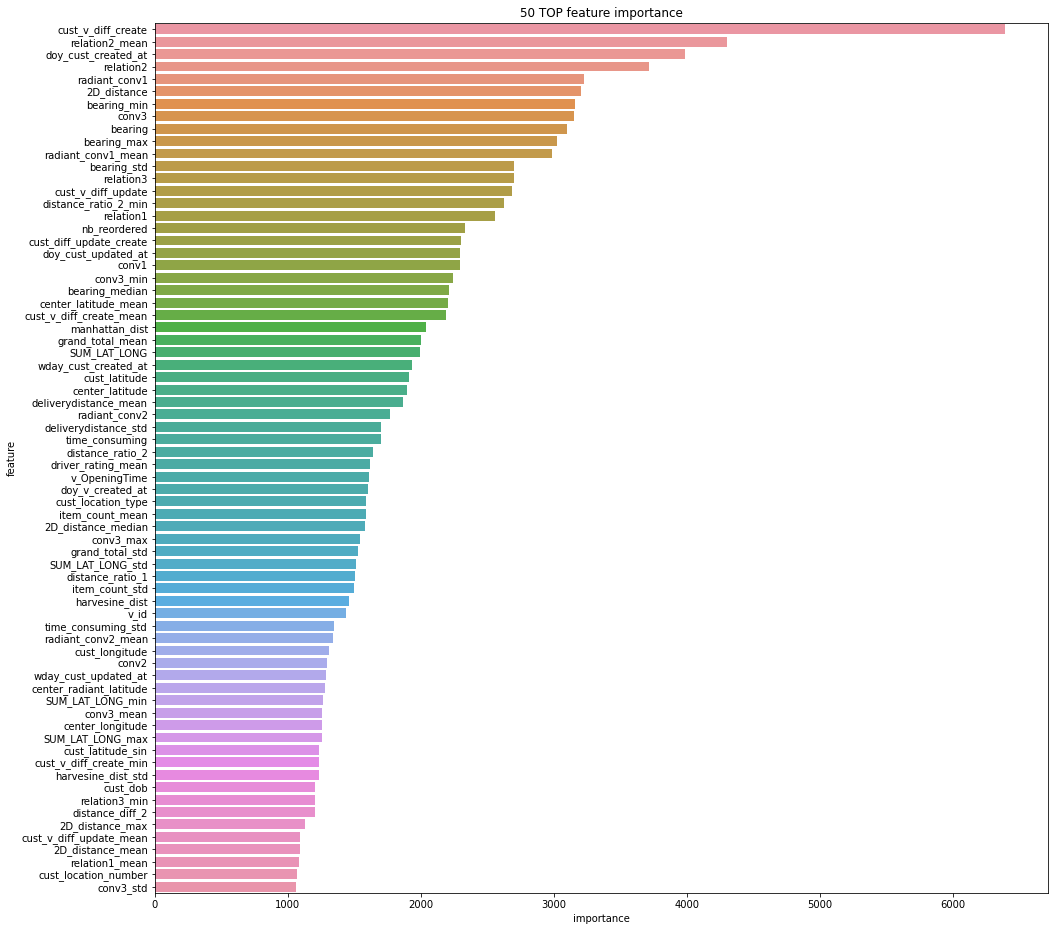

In [ ]:
plt.figure(figsize=(16, 16))
sns.barplot(data=importance_df.sort_values(by='importance', ascending=False).head(70), x='importance', y='feature');
plt.title('50 TOP feature importance');